# Sales Prediction using Multiple Linear Regression

## 1. Introduction

### Project Overview

This project builds a machine learning model to predict sales amounts based on historical sales data. We use Multiple Linear Regression (MLR), a statistical technique that models the relationship between multiple independent variables (features) and a dependent variable (sales amount).

### Business Problem Definition

In retail and e-commerce, predicting sales is crucial for inventory management, resource allocation, and revenue forecasting. Inaccurate predictions can lead to overstocking, stockouts, or missed opportunities. This model helps businesses anticipate sales based on factors like quantity sold, discounts, product category, and more.

### Objective 

The goal is to predict the Sales_Amount using features from the dataset, evaluate the model's performance, and interpret how each factor influences sales. This provides actionable insights for sales strategies.

## 2. Libraries Importation

In [ ]:
# Libraries for data manipulation
import pandas as pd  
import numpy as np   # For numerical operations and arrays

# Libraries for visualization
import matplotlib.pyplot as plt  # For basic plotting
import seaborn as sns            # For advanced visualizations like heatmaps

# Scikit-learn modules for ML
from sklearn.model_selection import train_test_split  # For splitting data
from sklearn.linear_model import LinearRegression     # For Multiple Linear Regression model
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # For encoding categoricals and scaling
from sklearn.compose import ColumnTransformer         # For applying transformations to columns
from sklearn.pipeline import Pipeline                 # For chaining preprocessing and model steps
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # For evaluation metrics

## 3. Dataset Loading and Inspection

In [2]:
# Load the CSV file
df = pd.read_csv('../data/sales_data.csv') 

# Display first few rows
print("First 5 rows:")
display(df.head())


First 5 rows:


,Product_ID,Sale_Date,Sales_Rep,Region,Sales_Amount,Quantity_Sold,Product_Category,Unit_Cost,Unit_Price,Customer_Type,Discount,Payment_Method,Sales_Channel,Region_and_Sales_Rep
0,1052,03/02/2023,Bob,North,5053.97,18,Furniture,152.75,267.22,Returning,0.09,Cash,Online,North-Bob
1,1093,21/04/2023,Bob,West,4384.02,17,Furniture,3816.39,4209.44,Returning,0.11,Cash,Retail,West-Bob
2,1015,21/09/2023,David,South,4631.23,30,Food,261.56,371.40,Returning,0.20,Bank Transfer,Retail,South-David
3,1072,24/08/2023,Bob,South,2167.94,39,Clothing,4330.03,4467.75,New,0.02,Credit Card,Retail,South-Bob
4,1061,24/03/2023,Charlie,East,3750.20,13,Electronics,637.37,692.71,New,0.08,Credit Card,Online,East-Charlie


In [ ]:


# Display shape and column names
print(f"Shape: {df.shape}")
print("Column Names:", df.columns.tolist())

Shape: (1000, 14)
Column Names: ['Product_ID', 'Sale_Date', 'Sales_Rep', 'Region', 'Sales_Amount', 'Quantity_Sold', 'Product_Category', 'Unit_Cost', 'Unit_Price', 'Customer_Type', 'Discount', 'Payment_Method', 'Sales_Channel', 'Region_and_Sales_Rep']


'\n- Product_ID: Unique identifier for the product (integer, likely categorical).\n- Sale_Date: Date of the sale (string, needs conversion to datetime).\n- Sales_Rep: Name of the sales representative (categorical: Alice, Bob, Charlie, David, Eve).\n- Region: Geographic region of the sale (categorical: North, South, East, West).\n- Sales_Amount: Total sales value (float, target variable to predict).\n- Quantity_Sold: Number of units sold (integer, key predictor).\n- Product_Category: Type of product (categorical: Furniture, Food, Clothing, Electronics).\n- Unit_Cost: Cost per unit (float).\n- Unit_Price: Selling price per unit (float).\n- Customer_Type: Type of customer (categorical: New, Returning).\n- Discount: Discount percentage applied (float, between 0 and 0.3).\n- Payment_Method: Payment type (categorical: Cash, Credit Card, Bank Transfer).\n- Sales_Channel: Channel of sale (categorical: Online, Retail).\n- Region_and_Sales_Rep: Combined region and rep (categorical, derived; may 

In [4]:

# Identify target and independent variables
target = 'Sales_Amount'
features = df.columns.drop(target).tolist()  # All others are potential independents
print("Target Variable:", target)
print("Independent Variables:", features)

Target Variable: Sales_Amount
Independent Variables: ['Product_ID', 'Sale_Date', 'Sales_Rep', 'Region', 'Quantity_Sold', 'Product_Category', 'Unit_Cost', 'Unit_Price', 'Customer_Type', 'Discount', 'Payment_Method', 'Sales_Channel', 'Region_and_Sales_Rep']


## 4. Data Cleaning & Preprocessing

In [ ]:
# Handle missing values if any
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 Product_ID              0
Sale_Date               0
Sales_Rep               0
Region                  0
Sales_Amount            0
Quantity_Sold           0
Product_Category        0
Unit_Cost               0
Unit_Price              0
Customer_Type           0
Discount                0
Payment_Method          0
Sales_Channel           0
Region_and_Sales_Rep    0
dtype: int64


In [6]:

# Remove duplicates
print("Duplicates:", df.duplicated().sum())
df = df.drop_duplicates()


Duplicates: 0


In [7]:

# Convert data types
df['Sale_Date'] = pd.to_datetime(df['Sale_Date'], format='%d/%m/%Y')  # Convert to datetime

# Extract date features (e.g., month, year) for potential use
df['Sale_Month'] = df['Sale_Date'].dt.month
df['Sale_Year'] = df['Sale_Date'].dt.year
df['Sale_Day'] = df['Sale_Date'].dt.day
df = df.drop('Sale_Date', axis=1)  # Drop original date

# Drop derived column to avoid multicollinearity
df = df.drop('Region_and_Sales_Rep', axis=1)

# Identify categorical and numerical columns
categorical_cols = ['Sales_Rep', 'Region', 'Product_Category', 'Customer_Type', 'Payment_Method', 'Sales_Channel']
numerical_cols = ['Product_ID', 'Quantity_Sold', 'Unit_Cost', 'Unit_Price', 'Discount', 'Sale_Month', 'Sale_Year', 'Sale_Day']

# Encode categorical variables using OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cats = pd.DataFrame(encoder.fit_transform(df[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols))
df = pd.concat([df.drop(categorical_cols, axis=1), encoded_cats], axis=1)

# Feature scaling (optional for LR, but helps with coefficient interpretation and if features have different scales)
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print("Preprocessed Data Shape:", df.shape)
display(df.head())

# Why scaling? Linear Regression doesn't require it, but it standardizes features (mean=0, std=1), making coefficients comparable and improving numerical stability.

Preprocessed Data Shape: (1000, 29)


,Product_ID,Sales_Amount,Quantity_Sold,Unit_Cost,Unit_Price,Discount,Sale_Month,Sale_Year,Sale_Day,Sales_Rep_Alice,...,Product_Category_Electronics,Product_Category_Food,Product_Category_Furniture,Customer_Type_New,Customer_Type_Returning,Payment_Method_Bank Transfer,Payment_Method_Cash,Payment_Method_Credit Card,Sales_Channel_Online,Sales_Channel_Retail
0,0.063332,5053.97,-0.519717,-1.638876,-1.734854,-0.715842,-1.272964,-0.054855,-1.473912,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.450401,4384.02,-0.590379,0.946317,1.043921,-0.486369,-0.707956,-0.054855,0.577303,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,-1.188414,4631.23,0.328224,-1.562095,-1.661420,0.546261,0.704566,-0.054855,0.577303,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,0.739951,2167.94,0.964180,1.308759,1.225997,-1.518998,0.422061,-0.054855,0.919172,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.367810,3750.20,-0.873026,-1.296911,-1.434937,-0.830579,-0.990460,-0.054855,0.919172,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


## 5. Exploratory Data Analysis (EDA)

In [8]:
# Summary statistics
print("Summary Statistics:")
display(df.describe())


Summary Statistics:


,Product_ID,Sales_Amount,Quantity_Sold,Unit_Cost,Unit_Price,Discount,Sale_Month,Sale_Year,Sale_Day,Sales_Rep_Alice,...,Product_Category_Electronics,Product_Category_Food,Product_Category_Furniture,Customer_Type_New,Customer_Type_Returning,Payment_Method_Bank Transfer,Payment_Method_Cash,Payment_Method_Credit Card,Sales_Channel_Online,Sales_Channel_Retail
count,1.000000e+03,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1000.00000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.411404e-15,5019.265230,-3.552714e-17,-2.096101e-16,-1.376677e-16,3.552714e-17,-7.815970e-17,1.297165e-12,8.881784e-17,0.19200,...,0.246000,0.226000,0.260000,0.504000,0.496000,0.342000,0.313000,0.345000,0.488000,0.512000
std,1.000500e+00,2846.790126,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,0.39407,...,0.430894,0.418448,0.438854,0.500234,0.500234,0.474617,0.463946,0.475606,0.500106,0.500106
min,-1.662048e+00,100.120000,-1.720967e+00,-1.704126e+00,-1.805412e+00,-1.748472e+00,-1.555469e+00,-5.485460e-02,-1.701825e+00,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.839356e-01,2550.297500,-8.730261e-01,-8.728172e-01,-8.594937e-01,-8.305786e-01,-9.904601e-01,-5.485460e-02,-9.041301e-01,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.950061e-02,5019.300000,-2.508493e-02,-5.694156e-03,-2.258430e-02,-2.742206e-02,-1.429472e-01,-5.485460e-02,7.521122e-03,0.00000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,8.414439e-01,7507.445000,8.935180e-01,8.662095e-01,8.666657e-01,8.904711e-01,9.870701e-01,-5.485460e-02,9.191723e-01,0.00000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.687218e+00,9989.040000,1.670797e+00,1.778197e+00,1.912828e+00,1.693628e+00,1.552079e+00,1.823001e+01,1.716867e+00,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


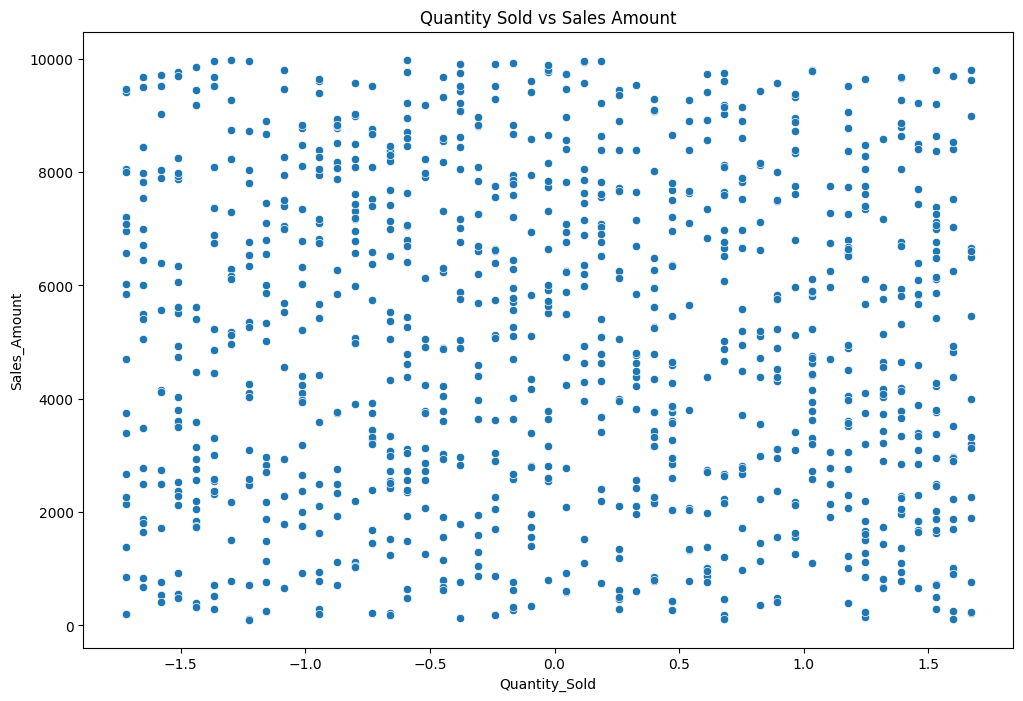

In [9]:

# Visualize relationships (e.g., scatter plots for numerical features vs sales)
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Quantity_Sold', y='Sales_Amount', data=df)
plt.title('Quantity Sold vs Sales Amount')
plt.show()


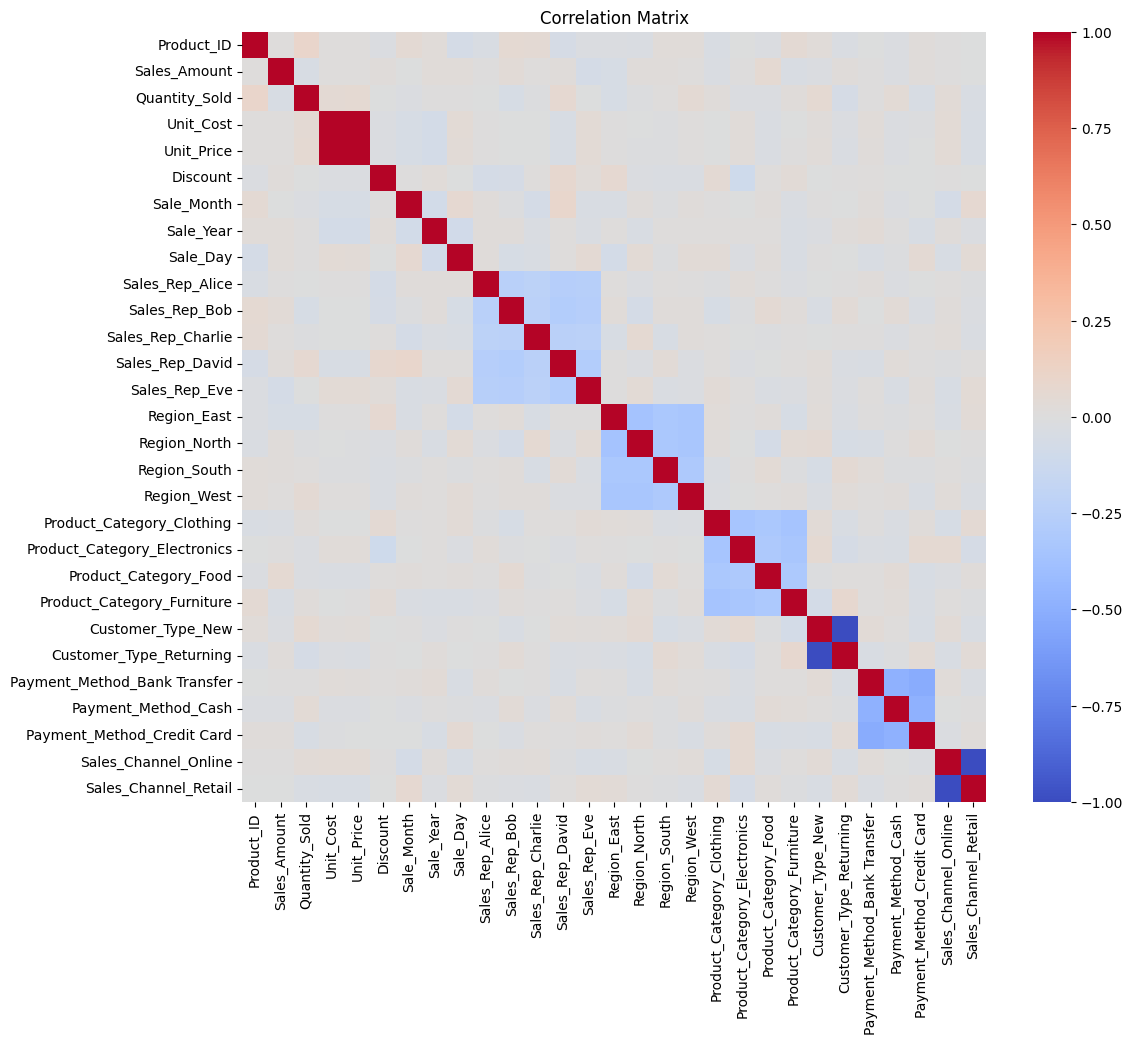

In [10]:

# Correlation matrix (only numerical for simplicity)
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Insights:
# - Sales_Amount may positively correlate with Quantity_Sold and Unit_Price (higher quantity/price leads to higher sales).
# - Discount might negatively correlate (higher discounts reduce sales amount).
# - Categories like Electronics could show higher sales than Food (business: target high-value categories).
# - Regions/Sales_Reps vary in performance (business: allocate resources to top performers).
# These insights help identify key drivers for sales predictions.

## 6. Feature Selection & Engineering 

In [11]:
# Select relevant features (drop low-correlation or redundant ones; here, all except target)
# For demo, use all preprocessed features
selected_features = df.columns.drop('Sales_Amount').tolist()
X = df[selected_features]
y = df['Sales_Amount']

# Check for multicollinearity (Variance Inflation Factor - VIF; >10 indicates issue)
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print("VIF Scores (check for >10):\n", vif_data)


VIF Scores (check for >10):
                          feature         VIF
0                     Product_ID    1.036744
1                  Quantity_Sold    1.033444
2                      Unit_Cost  103.221422
3                     Unit_Price  103.216724
4                       Discount    1.030109
5                     Sale_Month    1.040052
6                      Sale_Year    1.030724
7                       Sale_Day    1.036354
8                Sales_Rep_Alice         inf
9                  Sales_Rep_Bob         inf
10             Sales_Rep_Charlie         inf
11               Sales_Rep_David         inf
12                 Sales_Rep_Eve         inf
13                   Region_East         inf
14                  Region_North         inf
15                  Region_South         inf
16                   Region_West         inf
17     Product_Category_Clothing         inf
18  Product_Category_Electronics         inf
19         Product_Category_Food         inf
20    Product_Category_Fur

c:\Users\Kabrel\Desktop\sales-prediction\venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [12]:


# If high VIF, drop features (e.g., if Unit_Price and Unit_Cost are collinear)

# Explain MLR Assumptions:
"""
- Linearity: Relationship between features and target is linear (check via scatter plots).
- Independence: Observations are independent (assumed in sales data).
- Homoscedasticity: Constant variance of residuals (check post-model).
- Normality: Residuals are normally distributed (check QQ plot post-model).
- No multicollinearity: Features not highly correlated (use VIF).
If assumptions violated, results may be unreliable; consider transformations or other models.
"""

'\n- Linearity: Relationship between features and target is linear (check via scatter plots).\n- Independence: Observations are independent (assumed in sales data).\n- Homoscedasticity: Constant variance of residuals (check post-model).\n- Normality: Residuals are normally distributed (check QQ plot post-model).\n- No multicollinearity: Features not highly correlated (use VIF).\nIf assumptions violated, results may be unreliable; consider transformations or other models.\n'

## 7. Train-Test Split

In [13]:
# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train Shape:", X_train.shape)
print("Test Shape:", X_test.shape)

# Why necessary? Prevents overfitting; trains on one subset, evaluates on unseen data for realistic performance.

Train Shape: (800, 28)
Test Shape: (200, 28)


## 8. Model Building - Multiple Linear Regression

In [14]:
# Implement MLR
model = LinearRegression()

# Explain:
"""
Model Equation: Sales_Amount = β0 + β1*Feature1 + β2*Feature2 + ... + ε
- β0: Intercept (base sales when all features=0).
- βi: Coefficients (change in sales per unit change in feature i, holding others constant).
- ε: Error term.
Coefficients show feature impact (positive: increases sales; negative: decreases).
"""

'\nModel Equation: Sales_Amount = β0 + β1*Feature1 + β2*Feature2 + ... + ε\n- β0: Intercept (base sales when all features=0).\n- βi: Coefficients (change in sales per unit change in feature i, holding others constant).\n- ε: Error term.\nCoefficients show feature impact (positive: increases sales; negative: decreases).\n'

## 9. Model Training

In [15]:
# Train the model
model.fit(X_train, y_train)

print("Model Trained!")

# How it learns: Uses Ordinary Least Squares (OLS) to minimize sum of squared residuals between predicted and actual sales.

Model Trained!


## 10. Model Evaluation

In [16]:
# Predict on test set
y_pred = model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f} (Average error in sales prediction)")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f} (Error in same units as sales)")
print(f"R² Score: {r2:.2f} (Explains {r2*100:.0f}% of variance in sales)")

# Interpretation: If RMSE is 1000, predictions are off by ~$1000 on average. Good R² (>0.7) means model captures sales patterns well; low means need better features/models.

MAE: 2749.67 (Average error in sales prediction)
MSE: 9610196.21
RMSE: 3100.03 (Error in same units as sales)
R² Score: -0.04 (Explains -4% of variance in sales)


## 11. Model Interpretation

In [17]:
# Analyze coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
print("Coefficients:\n", coefficients.sort_values('Coefficient', ascending=False))

# Explanation:
# - Positive coeff (e.g., Quantity_Sold): Increasing quantity boosts sales.
# - Negative coeff (e.g., Discount): Higher discounts reduce net sales.
# Most influential: Features with largest absolute coefficients (e.g., Unit_Price, Quantity_Sold drive revenue).

Coefficients:
                          Feature  Coefficient
3                     Unit_Price   655.090818
11               Sales_Rep_David   376.092685
14                  Region_North   275.297614
19         Product_Category_Food   200.308404
22       Customer_Type_Returning   141.286680
7                       Sale_Day    91.568677
6                      Sale_Year    84.670837
9                  Sales_Rep_Bob    48.849247
8                Sales_Rep_Alice    48.803695
0                     Product_ID    45.820055
18  Product_Category_Electronics    39.030932
4                       Discount    36.907161
16                   Region_West    33.213083
5                     Sale_Month    25.975994
26          Sales_Channel_Online     9.803991
23  Payment_Method_Bank Transfer     5.722374
24           Payment_Method_Cash    -0.451125
25    Payment_Method_Credit Card    -5.271249
27          Sales_Channel_Retail    -9.803991
15                  Region_South   -19.979618
1                  

## 12. Sales Prediction with New Data

In [18]:
# Example new data (must match preprocessed format; in practice, apply same encoding/scaling)
# Assume a sample input (adjust values)
new_data = pd.DataFrame({
    'Product_ID': [1052], 'Quantity_Sold': [18], 'Unit_Cost': [152.75], 'Unit_Price': [267.22],
    'Discount': [0.09], 'Sale_Month': [3], 'Sale_Year': [2023], 'Sale_Day': [2],
    # Encoded categoricals (one-hot; set 1 for true category, 0 others)
    'Sales_Rep_Alice': [0], 'Sales_Rep_Bob': [1], 'Sales_Rep_Charlie': [0], 'Sales_Rep_David': [0], 'Sales_Rep_Eve': [0],
    'Region_East': [0], 'Region_North': [1], 'Region_South': [0], 'Region_West': [0],
    'Product_Category_Clothing': [0], 'Product_Category_Electronics': [0], 'Product_Category_Food': [0], 'Product_Category_Furniture': [1],
    'Customer_Type_New': [0], 'Customer_Type_Returning': [1],
    'Payment_Method_Bank Transfer': [0], 'Payment_Method_Cash': [1], 'Payment_Method_Credit Card': [0],
    'Sales_Channel_Online': [1], 'Sales_Channel_Retail': [0]
})

# Scale numerical cols in new_data (using same scaler)
new_data[numerical_cols] = scaler.transform(new_data[numerical_cols])

# Predict
predicted_sales = model.predict(new_data)
print(f"Predicted Sales Amount: ${predicted_sales[0]:.2f}")

# The predicted sales amount is the model's estimated total revenue (Sales_Amount) for one specific sales transsaction based on the input features provided.

Predicted Sales Amount: $4926.91


## 13. Business Use Case

Companies can use this model to:
- Forecast daily/weekly sales for budgeting.
- Optimize discounts (e.g. avoid high discounts on high-margin products).
- Identify top-performing reps/regions for incentives.

Limitations of Multiple Linear Regression:
- Assumes linear relationships (real sales may be non-linear).
- Sensitive to outliers/multicollinearity.
- Doesn't capture interactions unless engineered.

Upgrade to advanced models (e.g., Random Forest or XGBoost) if non-linear relationships or higher predictive accuracy are required. However, Multiple Linear Regression was used in this study as it was mandated by institutional (school) requirements.